In [1]:
from fastai2.vision.all import *
from fastai2.callback.tensorboard import *
from knockknock import email_sender

In [2]:
%load_ext tensorboard
%tensorboard --logdir logs --host=0.0.0.0 --port=5995

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 5995 (pid 26493), started 0:25:53 ago. (Use '!kill 26493' to kill it.)

In [2]:
root_dir = Path('/')
data_dir = root_dir / 'data' / 'chest_xray'
model_dir = Path('.').absolute() / 'models'
log_dir = Path('.').absolute() / 'logs'

In [3]:
sz = 256
lr = defaults.lr
bs = 64
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

In [4]:
def valid_func(o: Path):
    return 'test' in str(o)

def label_func(o: Path):
    if 'virus' in o.name:
        return 'pneumonia'
    if 'bacteria' in o.name:
        return 'pneumonia'
    return 'normal'

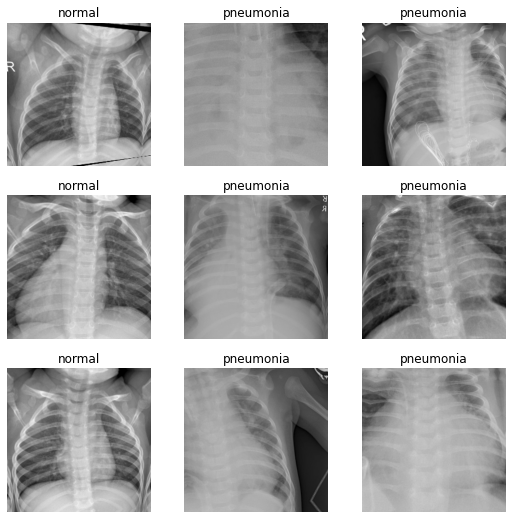

In [5]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=FuncSplitter(valid_func),
                 get_y=label_func,
                 item_tfms=Resize(sz*2),
                 batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*stats)])

data = db.dataloaders(data_dir)
data.show_batch(max_n=9)

In [6]:
learn = cnn_learner(data,
                    resnet50,
                    metrics=error_rate,
                    bn_wd=False,
                    loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[BnFreeze,
                          SaveModelCallback(monitor='error_rate', fname='best_error'),
                          ShowGraphCallback,
                          TensorBoardCallback(log_dir=log_dir, trace_model=False),
                        ],
                    model_dir=model_dir,
                   ).to_fp16()

In [7]:
@email_sender(recipient_emails=["yyang@hbku.edu.qa"], sender_email="hbkubot@gmail.com")
@delegates(learn.fit_one_cycle)
def train(learn, name, lr, n_epochs=5, **kwargs): # must be called kwargs, not kw_args or anything else
    learn.fit_one_cycle(n_epochs, lr, **kwargs)
    learn.save(name)

In [8]:
learn.smooth_loss = 0 # To fix the problem that TensorBoard reads this before Recorder writes it.

epoch,train_loss,valid_loss,error_rate,time
0,0.660835,0.759356,0.161859,00:19
1,0.464536,0.541958,0.153846,00:18
2,0.363354,0.460930,0.128205,00:18
3,0.316403,0.434187,0.121795,00:18
4,0.295309,0.425276,0.123397,00:18


Better model found at epoch 0 with error_rate value: 0.16185897588729858.


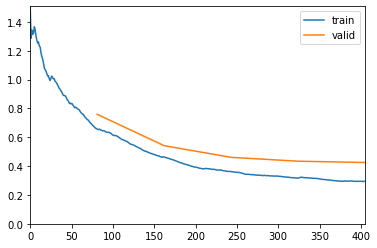

Better model found at epoch 1 with error_rate value: 0.1538461595773697.
Better model found at epoch 2 with error_rate value: 0.12820513546466827.
Better model found at epoch 3 with error_rate value: 0.12179487198591232.


In [9]:
train(learn, 'stage_1', lr)

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=6.309573450380412e-07)

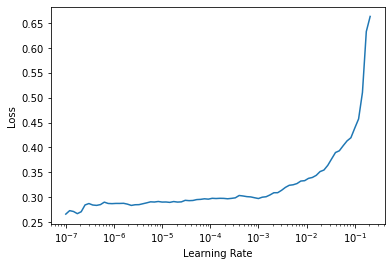

In [10]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,0.306647,0.407407,0.107372,00:22
1,0.293971,0.413233,0.115385,00:22
2,0.276235,0.410832,0.116987,00:22
3,0.260474,0.400631,0.118590,00:22
4,0.256056,0.409607,0.121795,00:22


Better model found at epoch 0 with error_rate value: 0.10737179219722748.


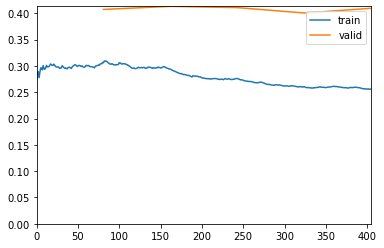

In [11]:
lr = 3e-4
train(learn, 'stage_2', slice(lr/100, lr))

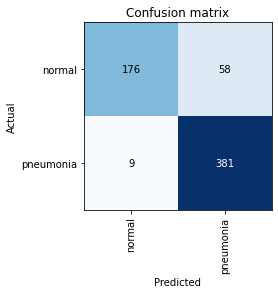

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()